In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
# Load the JSON file into a DataFrame
json_file_path = 'modeling_lysin_b_df.json'
modeling_lysin_b_df = pd.read_json(json_file_path, orient='records', lines=True)

modeling_lysin_b_df.head()

,GeneID,phams,Name,translation,PhageID,HostStrain,Cluster,LysinType,Molecular_Weight,Aromaticity,...,Hydrophobicity_Score,Molecular_Weight_Score,Protein_Length_Score,Hamming_Distance_Score,Stability_Score,Size_Score,Similarity_Score,Treatment_Score,HostStrain_Encoded,Cluster_Encoded
0,20ES_CDS_10,152741,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,20ES,Mycobacterium,A2,lysin_B,36578.3514,0.107692,...,0.770530,0.467192,0.535849,0.588983,0.549497,0.501521,0.588983,0.602633,1,7
1,32HC_CDS_37,3452,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,32HC,Mycobacterium,Z,lysin_B,41216.7621,0.091384,...,0.275950,0.302072,0.316981,0.309322,0.422740,0.309526,0.309322,0.329384,1,144
2,39HC_CDS_42,152741,39HC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,39HC,Mycobacterium,B6,lysin_B,35566.7986,0.084592,...,0.722025,0.503202,0.513208,0.550847,0.376510,0.508205,0.550847,0.539397,1,28
3,40AC_CDS_14,152741,40AC,MSLTLGSQGEIVNRWIRVMKARFVSYAGKLREDAYFGLDDAEVQKE...,40AC,Mycobacterium,A17,lysin_B,36595.5658,0.104615,...,0.699010,0.466580,0.535849,0.588983,0.486452,0.501214,0.588983,0.568915,1,5
4,40BC_CDS_42,152741,40BC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,40BC,Mycobacterium,B6,lysin_B,35566.7986,0.084592,...,0.722025,0.503202,0.513208,0.550847,0.376510,0.508205,0.550847,0.539397,1,28


In [3]:
# Define features and target variable
features = ['Isoelectric_Point', 'Aromaticity', 'Instability_Index', 'Aliphatic_Index',
            'Gravy', 'Hydrophobicity', 'Molecular_Weight', 'Protein_Length',
            'Hamming_Distance', 'HostStrain_Encoded']

X = modeling_lysin_b_df[features]
y = modeling_lysin_b_df['Treatment_Score']

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Convert the scaled arrays back to DataFrames for easier visualization and plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Convert y_train and y_test from Series to DataFrames
y_train_df = pd.DataFrame(y_train, columns=['Treatment_Score'])
y_test_df = pd.DataFrame(y_test, columns=['Treatment_Score'])

In [7]:
# Combine the scaled training features and target into one DataFrame
combined_train_df = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)

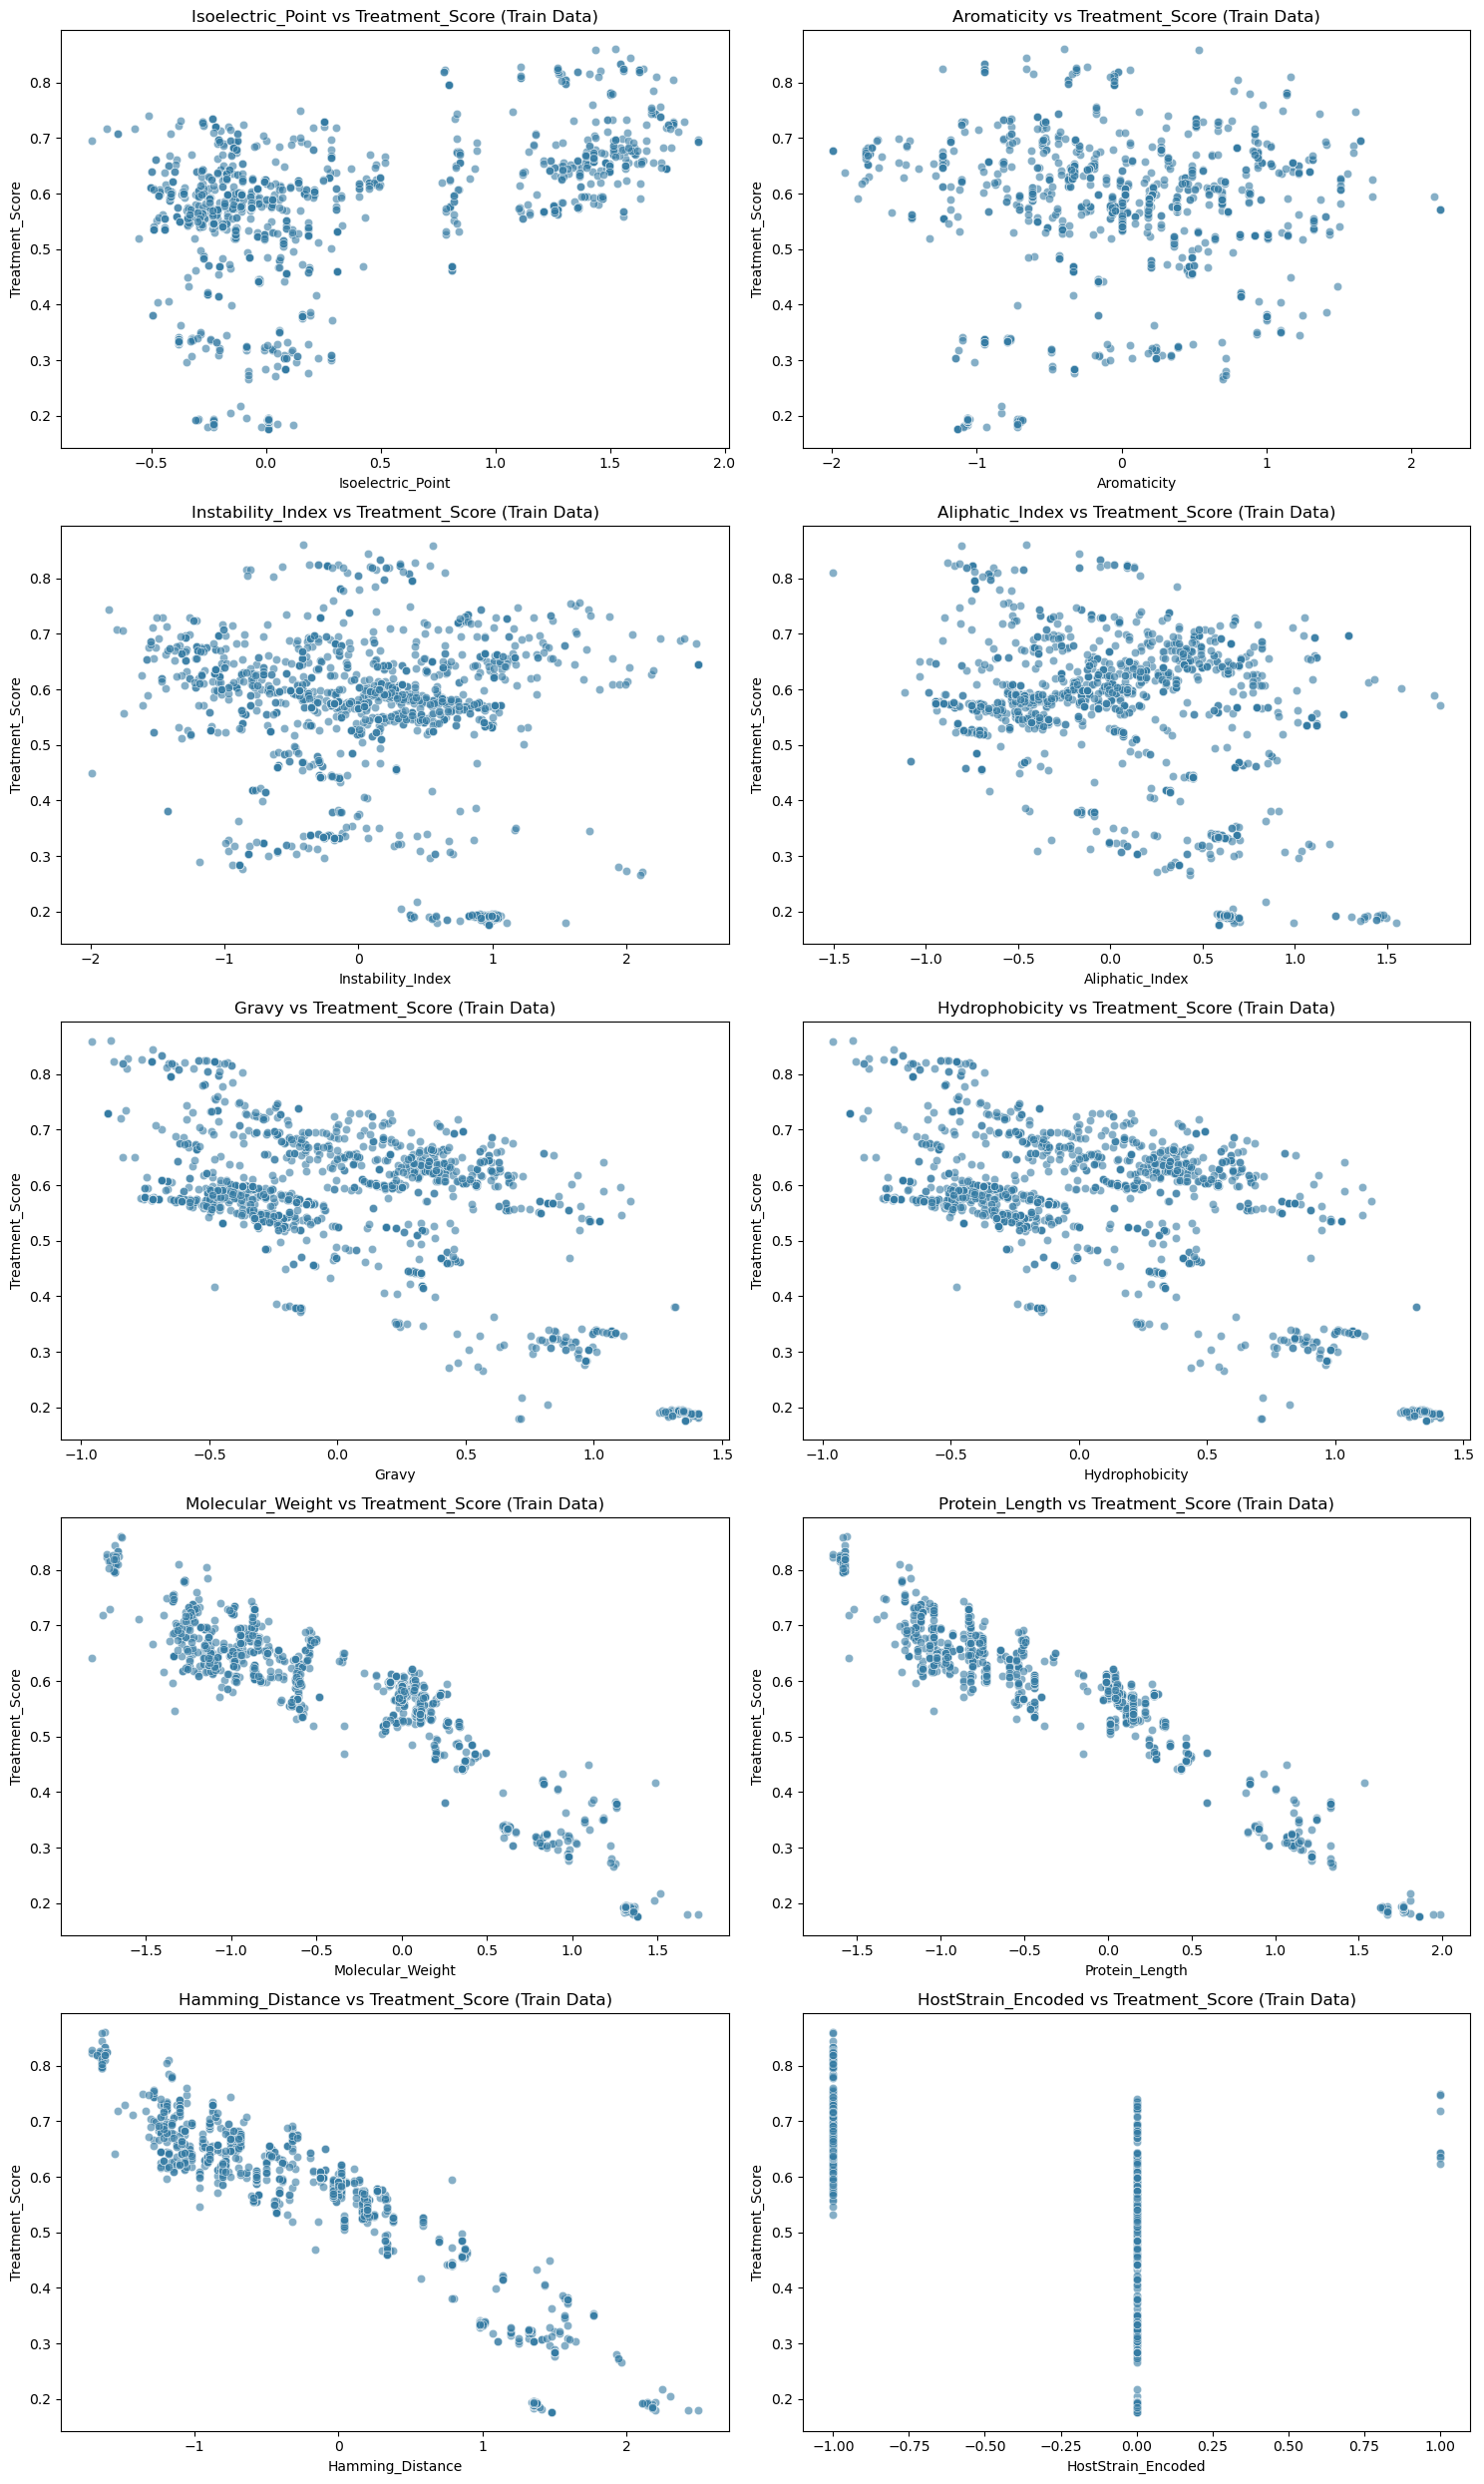

In [8]:
# Set up the plotting area for multiple scatter plots side by side
fig, axes = plt.subplots(nrows=len(X_train_scaled_df.columns) // 2 + len(X_train_scaled_df.columns) % 2, ncols=2, figsize=(15, 5 * (len(X_train_scaled_df.columns) // 2 + len(X_train_scaled_df.columns) % 2)))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each feature against Treatment_Score using a consistent color from the mako palette
for i, feature in enumerate(X_train_scaled_df.columns):
    sns.scatterplot(x=combined_train_df[feature], y=combined_train_df['Treatment_Score'], ax=axes[i], alpha=0.6, color=sns.color_palette("mako", as_cmap=True)(0.5))
    axes[i].set_title(f'{feature} vs Treatment_Score (Train Data)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Treatment_Score')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

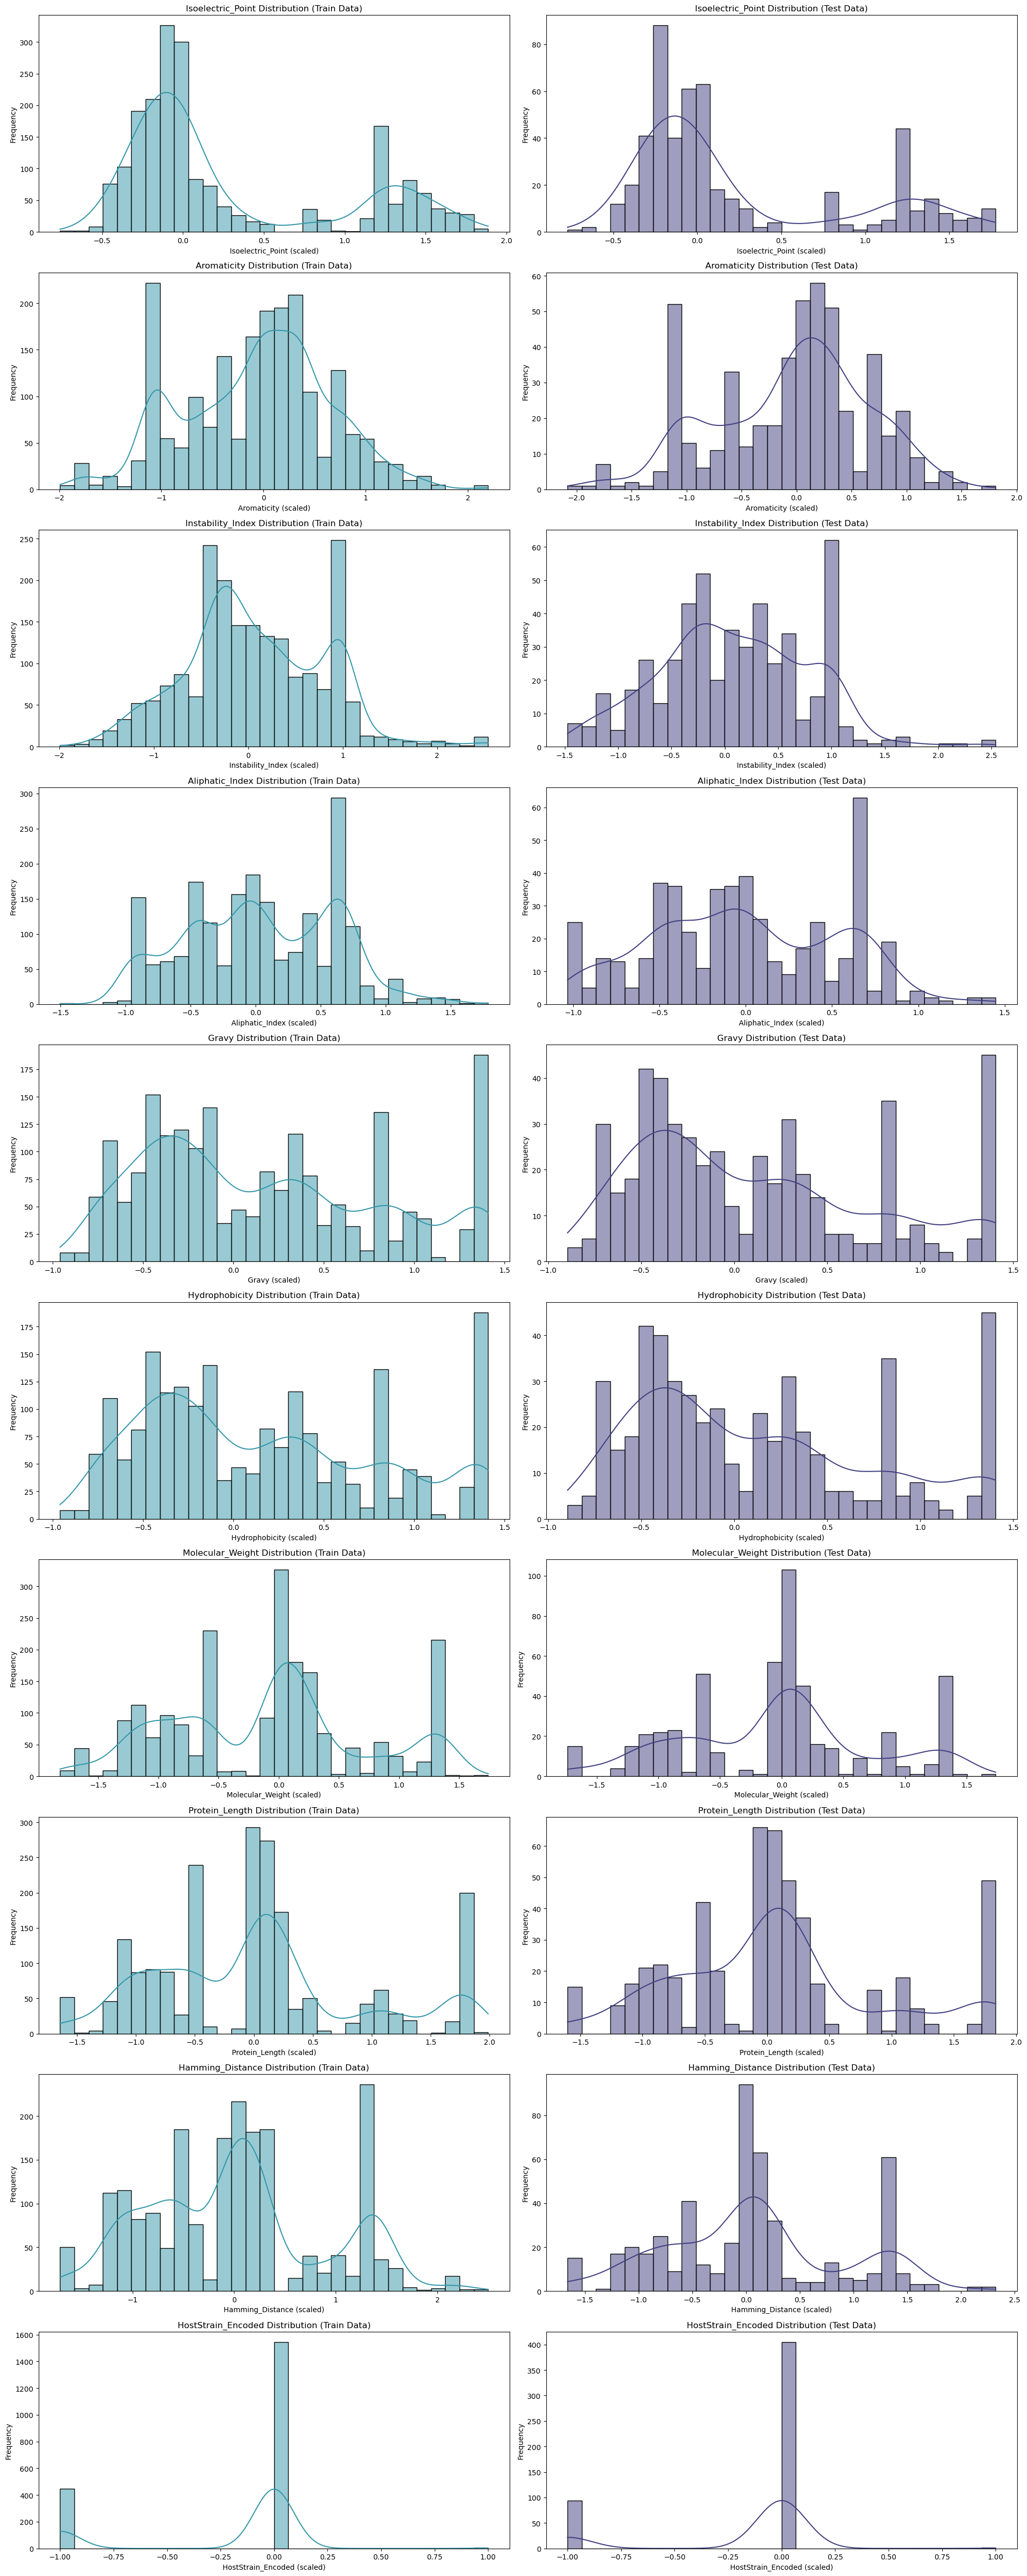

In [9]:
# Set up the matplotlib figure with 2 columns (one for train, one for test) and mako palette
fig, axes = plt.subplots(nrows=len(X_train_scaled_df.columns), ncols=2, figsize=(20, 5 * len(X_train_scaled_df.columns)))

# Loop through each feature and create a histogram for both training and test data
for index, column in enumerate(X_train_scaled_df.columns):
    # Use a specific color from the mako colormap
    train_color = sns.color_palette("mako", as_cmap=True)(0.6)  # Slightly darker shade for training data
    test_color = sns.color_palette("mako", as_cmap=True)(0.3)   # Lighter shade for test data
    
    sns.histplot(X_train_scaled_df[column], bins=30, kde=True, color=train_color, ax=axes[index, 0])
    axes[index, 0].set_title(f'{column} Distribution (Train Data)')
    axes[index, 0].set_xlabel(f'{column} (scaled)')
    axes[index, 0].set_ylabel('Frequency')
    
    sns.histplot(X_test_scaled_df[column], bins=30, kde=True, color=test_color, ax=axes[index, 1])
    axes[index, 1].set_title(f'{column} Distribution (Test Data)')
    axes[index, 1].set_xlabel(f'{column} (scaled)')
    axes[index, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Compare the means and standard deviations
comparison = pd.DataFrame({
    'Train Mean': X_train_scaled_df.mean(),
    'Test Mean': X_test_scaled_df.mean(),
    'Train Std': X_train_scaled_df.std(),
    'Test Std': X_test_scaled_df.std(),
})
print(comparison)

                    Train Mean  Test Mean  Train Std  Test Std
Isoelectric_Point     0.279321   0.226346   0.664716  0.637826
Aromaticity          -0.064663  -0.037886   0.709871  0.691392
Instability_Index     0.060758   0.082918   0.731565  0.689382
Aliphatic_Index       0.036514  -0.011304   0.569209  0.532933
Gravy                 0.149402   0.106858   0.646270  0.632605
Hydrophobicity        0.149402   0.106858   0.646270  0.632605
Molecular_Weight     -0.109944  -0.052868   0.802950  0.763767
Protein_Length        0.013562   0.063161   0.877542  0.834469
Hamming_Distance      0.000321   0.058918   0.867383  0.825948
HostStrain_Encoded   -0.219890  -0.183633   0.423821  0.397758


In [11]:
# KS test for feature distribution between train and test sets
ks_test_results = {column: ks_2samp(X_train_scaled_df[column], X_test_scaled_df[column]) for column in X_train_scaled_df.columns}
ks_test_results_df = pd.DataFrame(ks_test_results).T
ks_test_results_df.columns = ['KS Statistic', 'p-value']
print(ks_test_results_df)

                    KS Statistic   p-value
Isoelectric_Point       0.061975  0.087596
Aromaticity             0.048981  0.280575
Instability_Index       0.044092  0.403576
Aliphatic_Index         0.064094  0.070581
Gravy                   0.052932  0.202885
Hydrophobicity          0.052932  0.202885
Molecular_Weight        0.063292  0.076747
Protein_Length          0.067786  0.047681
Hamming_Distance        0.070914  0.033553
HostStrain_Encoded      0.036263  0.651126
